# Creating a classification model and comparing classifiers and feature extraction techniques

In [1]:
# importing libraries
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from skimage import data, exposure
import numpy as np
import pywt
import pywt.data
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
# first feature selection technique is HOG
def calculate_hog_features(image):
    hog_image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_AREA)
    fd, hog_image = hog(hog_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

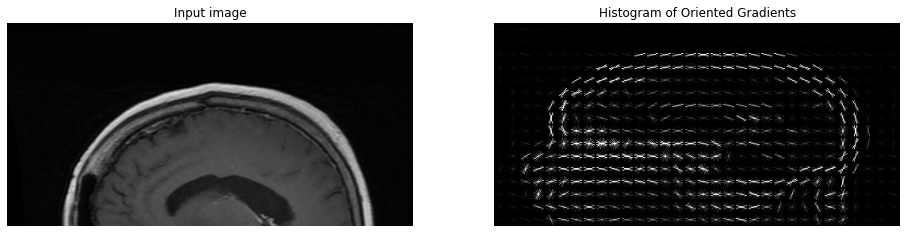

In [3]:
# showing example of what the hog features show

img = cv2.imread('./dataset/image/IMAGE_0000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fd, hog_image = calculate_hog_features(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [4]:
# second feature is wavelets with 'haar' feature

# adapting function so that I can apply the transform multiple times
def wavelet_feature(original, iterations):
    for i in range(iterations):
        coeffs = pywt.dwt2(original, 'haar')
        LL, (LH, HL, HH) = coeffs
        original = LL
    return coeffs
    

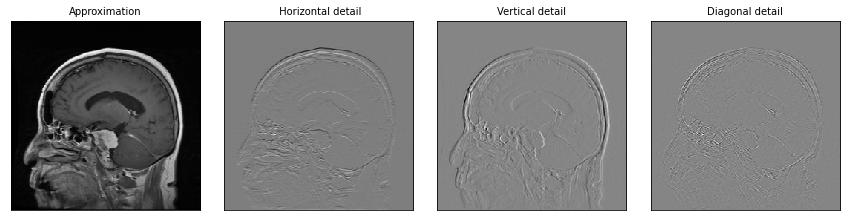

In [5]:
# Load image
original = cv2.imread('./dataset/image/IMAGE_0000.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs = wavelet_feature(original, 1)
LL, (LH, HL, HH) = coeffs
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [6]:
# saving features for comparisons
# creating directories for features to go in
try:
    os.mkdir('./features_task_a')
except:
    print('Directory already created')
try:
    os.mkdir('./features_task_a/train')
except:
    print('Directory already created')
try:
    os.mkdir('./features_task_a/test')
except:
    print('Directory already created')

Directory already created
Directory already created
Directory already created


In [26]:
# turning classes into numbers so that it can be used as a binary classifier
classes = {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 1, 'pituitary_tumor': 1}

# function to extract and save features for future use
def feature_extraction(train_test):
    df = pd.read_csv(f'./dataset/{train_test}.csv')
    hog_features = []
    wavelet_features = []
    labels = []
    for row in tqdm(df.iterrows()):
        image_name = row[1][0]
        label = row[1][1]
        # opening image
        img = cv2.imread(f'./dataset/{train_test}/{image_name}')
        
        # grayscaling image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # normalising images between 0 and 1
        img = img/255

        # resizing images to 256 pixels square

        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)


        # creating features and appending to arrays
        features, hog_image = calculate_hog_features(img)
        hog_features.append(features)

        features = wavelet_feature(img, 3)
        LL, (LH, HL, HH) = features
        wavelet_features.append(LL.flatten())

        # saving labels
        labels.append(classes[label])

    # saving so that it doesnt need to be run multiple times
    try:
        np.save(f'./features_task_a/{train_test}/hog', hog_features)
    except:
        print("Features already created")
    
    try:
        np.save(f'./features_task_a/{train_test}/wavelet_3x', wavelet_features)
    except:
        print("Features already created")

    try:
        np.save(f'./features_task_a/{train_test}/labels', labels)
    except:
        print("Features already created")

In [27]:
# running feaeture extraction
feature_extraction('train')
feature_extraction('test')

2100it [04:15,  8.22it/s]
900it [01:58,  7.59it/s]


In [ ]:
# selecting features and creating x_train, x_test, y_train, y_test

# testing hog features
x_train = np.load('./features_task_a/train/hog.npy')
y_train = np.load('./features_task_a/train/labels.npy')

x_test = np.load('./features_task_a/test/hog.npy')
y_test = np.load('./features_task_a/test/labels.npy')

In [12]:
# creating model and evaluating
# features will be an array of features which will be concatenated together from different feature extraction methods
def classifier(features_selected):
    x_train = []
    x_test = []
    for feature_type in features_selected:
        # loading features
        x_train.append(np.load(f'./features_task_a/train/{feature_type}.npy'))
        x_test.append(np.load(f'./features_task_a/test/{feature_type}.npy'))
    x_train = tuple(x_train)
    x_test = tuple(x_test)
    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    y_train = np.load(f'./features_task_a/train/labels.npy')
    y_test = np.load(f'./features_task_a/test/labels.npy')

    # scaling data

    scalar = StandardScaler()

    # scaling data to perform pca on it
    scalar.fit(x_train)

    # applying scale to xtrain and xtest
    x_train = scalar.transform(x_train)
    x_test = scalar.transform(x_test)

    # performing PCA on data

    # creating pca
    pca = PCA(n_components=100)

    # fitting pca on training data
    pca.fit(x_train)

    # applying to train and test
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)


    # creating SVM
    # creating and training SVM on training data
    # grid search to find optimal hyperparameters

    parameters = {'kernel':['rbf', 'linear'], 'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}

    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, refit=True, verbose = 3)
    clf.fit(x_train, y_train)

    return clf, x_test, y_test

In [13]:
import pickle

parameters = ['hog', 'wavelet_3x']
grid, x_test, y_test = classifier(parameters)


filename = f"./models/{'PCA100'.join(parameters)}.sav"
pickle.dump(grid, open(filename, 'wb'))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.819 total time=   1.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.867 total time=   2.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.812 total time=   2.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.848 total time=   1.7s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.848 total time=   2.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.717 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)


C:\Users\tkate\anaconda3\envs\amls-assignment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


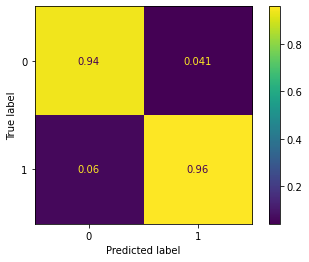

accuracy:  0.9533333333333334
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       260
           1       0.96      0.98      0.97       640

    accuracy                           0.95       900
   macro avg       0.95      0.94      0.94       900
weighted avg       0.95      0.95      0.95       900



In [ ]:
plot_confusion_matrix(grid, x_test, y_test, normalize='pred')
plt.show()

pred = grid.predict(x_test)
score = accuracy_score(y_test, pred)
print('accuracy: ', score)

# print classification report
print(classification_report(y_test, pred))